In [127]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Loading Data

In [128]:
N = 67_000_000 # La population 

df = pd.read_csv('data/covid-19_world.csv',sep=',')
df = df[ df["countriesAndTerritories"]=="France" ]
df.sort_values("dateRep")
for col_to_drop in ["day","month","year","countriesAndTerritories","geoId",
                    "countryterritoryCode","popData2018","continentExp"]:

    df=df.drop(col_to_drop,1)

df["dateRep"] = pd.to_datetime(df["dateRep"],format="%d/%m/%Y")
df = df.sort_values("dateRep")
df = df[df["dateRep"] > "2020-01-24"]
df["cases"] = df["cases"].cumsum()
df["deaths"] = df["deaths"].cumsum()
df["susceptible"] = df.apply(lambda row : N -(row["deaths"]+row["cases"]),axis=1)
df.head(10)

,dateRep,cases,deaths,susceptible
5624,2020-01-25,3,0,66999997
5623,2020-01-26,3,0,66999997
5622,2020-01-27,3,0,66999997
5621,2020-01-28,3,0,66999997
5620,2020-01-29,4,0,66999996
5619,2020-01-30,5,0,66999995
5618,2020-01-31,6,0,66999994
5617,2020-02-01,6,0,66999994
5616,2020-02-02,6,0,66999994
5615,2020-02-03,6,0,66999994


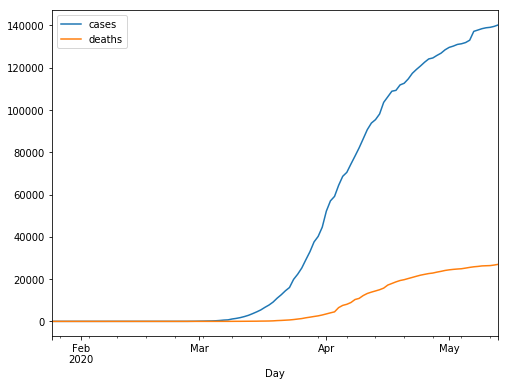

In [129]:
ax=df.plot(x="dateRep",y="cases",figsize=(8,6))
ax=df.plot(x="dateRep",y="deaths",ax=ax)
# ax=df.plot(x="dateRep",y="susceptible",ax=ax)
plt.xlabel('Day')
plt.show()

## SIR Model

In [133]:
class SIRModel():
    """
    SIR Model
    """
    def __init__(self, beta=0.1, gamma=0.1):
        self.beta_ = beta
        self.gamma_ = gamma
 
    def deriv(self, y0, t, N, beta, gamma):
        S, I, R = y0
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    def fit(self, t, N, I):
        I0 = I[0]
        y_0 = (N-I0, I0, 0)
        def f(t, beta, gamma):
            y_t = odeint(self.deriv, y_0, t, args=(N, beta, gamma))
            S,I,R = y_t.T # infected number
            return I
        params, pcov = curve_fit(f, t, I)
        return params
    
    def res(self, t, N, I):
        b, g =self.fit(t, N, I)
        I0 = I[0]
        y0 = (N-I0, I0, 0)
        ret = odeint(self.deriv, y0, t, args=(N, b, g))
        S,I,R=ret.T
        return S,I,R
    
    def plotfit(self, t, I, df):
        f, ax = plt.subplots(1,1)
        ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t,df["cases"].to_numpy(),'k', alpha=0.7, lw=2, label='Really infected')
        ax.set_xlabel('Time (days)')

        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        plt.show()
        
    def plotsir(self, t, S, I, R, df):
        f, ax = plt.subplots(1,1,figsize=(8,4))
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t,df["cases"].to_numpy(),'k', alpha=0.7, lw=2, label='Really infected')
#         ax.plot(t,df["susceptible"].to_numpy(), 'r', alpha=0.7, lw=2, label='Really Susceptible')
        ax.plot(t,df["deaths"].to_numpy(), 'c', alpha=0.7, lw=2, label='Really dead')
        ax.set_xlabel('Time (days)')

        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
          ax.spines[spine].set_visible(False)
        plt.show()

/home/klchai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/klchai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/home/klchai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/home/klchai/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


params: [1.90366878 1.77454346]


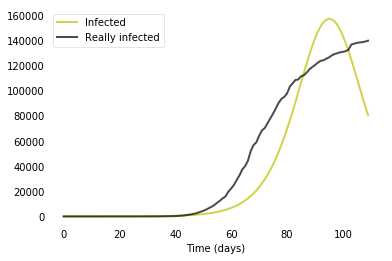

In [134]:
t = range(df.shape[0])
N = 67_000_000
I = df["cases"].to_numpy()

sir = SIRModel()
params = sir.fit(t, N, I)
print("params:",params)
S, I, R = sir.res(t,N,I)
sir.plotfit(t, I, df)

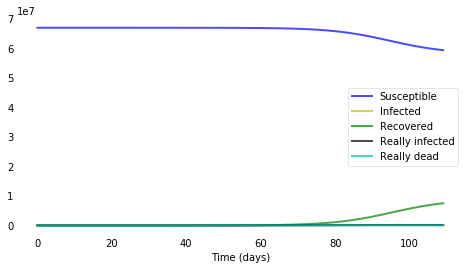

In [135]:
sir.plotsir(t, S, I, R,df)

## SEIR Model

In [136]:
def deriv_SEIR(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [137]:
N = 67_000_000
D = 10.0 # infections lasts 10 days
gamma = 1.0 / D
delta = 1.0 / 3.0  # incubation period of three days
R_0 = 5.0
beta = R_0 * gamma
S0, E0, I0, R0 = N-3, 3, 0, 0  # initial conditions: one exposed, rest susceptible
t = np.arange(0,100)
y0 = S0, E0, I0, R0

In [138]:
# Integrate the SEIR equations over the time grid, t.
ret = odeint(deriv_SEIR, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

In [139]:
def fit(t, bt, gma, delta):
    res = odeint(deriv_SEIR, y0, t, args=(N, bt, gma, delta))
    S, E, I, R = res.T
    return I

real = df["cases"].to_numpy()[:-10]
params, pcov = curve_fit(fit, t, real)
print(params)

b,g,l=params
ret_SEIR = odeint(deriv_SEIR, y0, t, args=(N, b, g, l))
S_n, E_n, I_n, R_n = ret_SEIR.T

[ 1.06738008  0.94481629 20.62422673]


In [140]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
#   ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
#   ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t,df["cases"].to_numpy()[:-10],'k', alpha=0.7, lw=2, label='Really infected')
#   ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

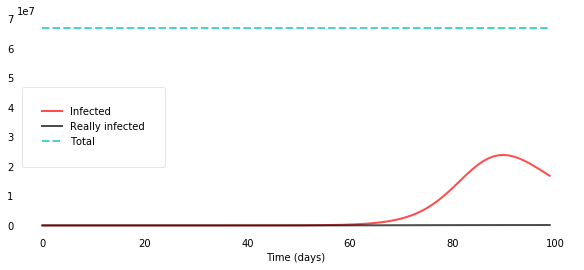

In [141]:
plotseird(t, S, E, I, R)

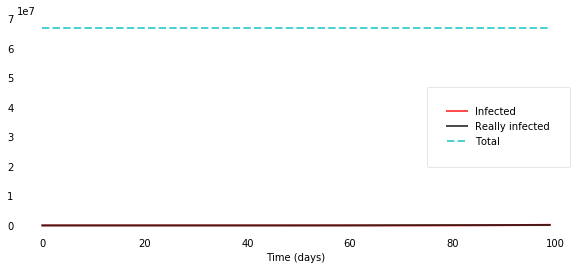

In [142]:
plotseird(t, S_n, E_n, I_n, R_n)